In [1]:
import numpy as np
import qililab as ql

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from qililab.utils import from_dict
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt


api = API(ConnectionConfiguration(username="qat", api_key="meow"))


api.select_device_id(9)
ql.logger.setLevel(40)  # Set qililab's logger to a higher level so it only shows error messages

2024-03-11 19:33:14,847 - qm - INFO     - Starting session: 9a794a14-d5ac-4c1c-b748-87cf5916d6c2


In [16]:
# Qubit to run the experiment on
QUBIT = 4

In [3]:
runcard = api.get_runcard(runcard_name="galadriel_qprogram")
runcard_as_dict = runcard.runcard

RO_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["duration"]
RO_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["amplitude"]
X_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["duration"]
X_num_sigmas_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"]["num_sigmas"]
X_drag_coefficient_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"][
    "drag_coefficient"
]
X_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["amplitude"]

In [14]:
X_amplitude_runcard

0.24641175677808694

# Rabi in amplitude

### Parameter definition

In [4]:
AMP_START = 0
AMP_STOP = 0.5
AMP_STEP = 0.001

NSHOTS = 1000

RO_DUR = RO_duration_runcard
RO_AMP = RO_amplitude_runcard
DRIVE_DUR = X_duration_runcard
DRIVE_SIGMAS = X_num_sigmas_runcard
DRIVE_DRAG_COEFF = X_drag_coefficient_runcard
time_of_flight = 120
relax_duration = 200_000

### QProgram definition

In [5]:
def Rabi_in_amplitude(
    qubit,
    amp_start,
    amp_stop,
    amp_step,
    averages,
    r_gain,
    r_duration,
    d_duration,
    d_sigmas,
    d_drag_coeff,
    relax_duration=200_000,
    time_of_flight=120,
):

    readout_waveform = ql.Square(amplitude=r_gain, duration=r_duration)  # square wavefront
    measure_weights = ql.Square(amplitude=1, duration=r_duration)
    drive_waveform = ql.IQPair.DRAG(
        amplitude=1,  ## will be modified within the qprogram
        duration=d_duration,
        num_sigmas=d_sigmas,
        drag_coefficient=d_drag_coeff,
    )

    qp_rabi = ql.QProgram()

    # Defining the variable Amplitude for the driving pulse
    amp = qp_rabi.variable(ql.Domain.Voltage)  # Possible domains: Scalar, Time, Frequency, Phase and Voltage

    # Averaging
    with qp_rabi.average(averages):
        # Loop over all amplitudes
        with qp_rabi.for_loop(variable=amp, start=amp_start, stop=amp_stop, step=amp_step):  # Shift in Hz
            # AMPLITUDE DEPENDENT DRAG PULSE
            qp_rabi.set_gain(bus=f"drive_q{qubit}_bus", gain=amp)  # adjusting the amplitude through gain
            qp_rabi.play(
                bus=f"drive_q{qubit}_bus", waveform=drive_waveform
            )  # executing the DRAG pulse for the Rabi sequence

            qp_rabi.sync()  # adding the sync implies that the next bus (for the readout) will execute after the previous (drive)

            # READOUT PULSE
            qp_rabi.play(bus=f"readout_q{qubit}_bus", waveform=readout_waveform, wait_time=time_of_flight)
            qp_rabi.acquire(
                bus=f"readout_q{qubit}_bus", weights=ql.IQPair(I=measure_weights, Q=measure_weights)
            )  # readout
            qp_rabi.wait(bus=f"readout_q{qubit}_bus", duration=relax_duration)  # Qubit relaxation wait
    return qp_rabi

In [6]:
amplitude = np.arange(AMP_START, AMP_STOP + AMP_STEP / 2, AMP_STEP)
qprogram_amplitude = Rabi_in_amplitude(
    QUBIT,
    AMP_START,
    AMP_STOP,
    AMP_STEP,
    NSHOTS,
    RO_AMP,
    RO_DUR,
    DRIVE_DUR,
    DRIVE_SIGMAS,
    DRIVE_DRAG_COEFF,
    time_of_flight=time_of_flight,
    relax_duration=relax_duration,
)

### Experiment execution

In [7]:
result_id = api.execute(qprogram=qprogram_amplitude.to_dict(), name="rabi amplitude")[0]
print(result_id)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1710256179, time: 1710256367(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/circuits"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1710256179, time: 1710256367(leeway: 60)"}



9724


###  De-serialising results and post-processing

In [10]:
results_amp = api.get_result(result_id)
qprogram_results_amp = from_dict(results_amp)

Your job with id 9724 is completed.


In [18]:
def dB(I, Q, RESONATOR_LO=7e9, RESONATOR_IF=40.7e6, delay=265e-9):
    S21 = I + 1j * Q
    S21 = S21 * np.exp(2 * np.pi * 1j * (RESONATOR_LO + RESONATOR_IF) * delay)
    return 20 * np.log10(np.abs(S21))


data = qprogram_results_amp
i_vec, q_vec = data.results[f"readout_q{QUBIT}_bus"][0].array
s21_vec = dB(i_vec, q_vec)

### Plotting

Optimized Parameters: [-1.08160541  1.88376232  5.77164186]


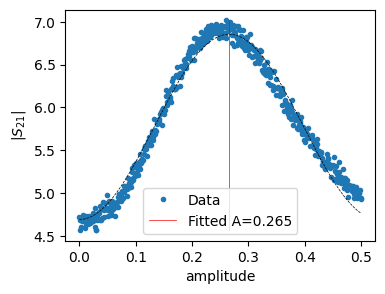

In [19]:
# Define the decaying exponential function
def cosine_fit(x, A, omega, C):
    return A * np.cos(2 * np.pi * omega * x) + C


xaxis = amplitude
fit_up2 = -1  # 20
# Generate some sample data
x_data = xaxis[:fit_up2]
y_data = s21_vec[:fit_up2]

# Fit the decaying exponential function to the data
initial_guess = [0.5, 2, 20]  # initial guess for the parameters A, omega, C
optimized_params, _ = curve_fit(cosine_fit, x_data, y_data, p0=initial_guess)

# Print the optimized parameters
print("Optimized Parameters:", optimized_params)

# Plot the data and the fitted function
plt.figure(figsize=(4, 3))
plt.plot(xaxis, s21_vec, "o", ms=3, label="Data")
plt.plot(
    x_data,
    cosine_fit(x_data, *optimized_params),
    "k--",
    lw=0.5,
)
max_osc = 1 / (2 * optimized_params[1])
plt.plot(
    [max_osc, max_osc],
    [np.min(s21_vec), np.max(s21_vec)],
    "r",
    lw=0.5,
    label=f"Fitted A={1/(2 * optimized_params[1]):.3f}",
)
plt.legend()
plt.xlabel("amplitude")
plt.ylabel("$|S_{21}|$")
plt.show()